# Anthropic Commodities Analysis Agent with Real-time News Access (built with LlamaIndex)

## Overview <br>
This system provides a comprehensive toolkit for analyzing commodities market data using the Financial Modeling Prep (FMP) API. It's designed to work within Google Colab notebooks and provides real-time commodities market analysis capabilities.

### Tools used:


1.   Anthropic API - Claude 3.5 Sonnett   
2.   LlamaIndex for orchestration
3.   Financial Modeling Prep API for commodities information
4.   News API to create up-to-date view on what's influencing commodities markets



In [3]:
from IPython.display import Image, display
display(Image('image_path.png'))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install llama-index-llms-anthropic -q
!pip install llama-index -q

In [ ]:
from llama_index.llms.anthropic import Anthropic
from llama_index.llms.openai import OpenAI
from llama_index.core.tools import FunctionTool

import nest_asyncio

nest_asyncio.apply()

## 2. Instantiate Anthropic and News API Keys

Step 1: Instantiate Baseline LLM to be used


*   Experiment 1: Use Claude Sonnet for tool use, code generation and parsing
*   Experiment 2: Use OpenAI o1 models to test reasoning capabilities



In [ ]:
from google.colab import userdata

CLAUDE_API_KEY = userdata.get('ANTHROPIC_API_KEY')
OAI_API_KEY = userdata.get('OPENAI_API_KEY')
FMP_API_KEY = userdata.get('FINANCIAL_MODELING_PREP_API_KEY')
NEWS_API_KEY = userdata.get('NEWS_API_KEY')

In [ ]:
openai_llm = OpenAI(model="gpt-4o-mini", api_key=OAI_API_KEY)

In [ ]:
anthropic_llm = Anthropic(model="claude-3-5-sonnet-20240620", api_key=CLAUDE_API_KEY)

Step 2: Instantiate News API for Retrieval

## 3. Define Classes and Tools for LLM Use

### 3.0 Core Components

#### CommoditiesTracker Class
The main class that handles data fetching and analysis of commodities market data.


##### Key Methods:

###### `__init__()`
* Initializes the tracker with FMP API credentials from Colab userdata
* Sets up the base URL for API calls
* Triggers initial data fetch

###### `_fetch_data()`
* Private method that retrieves fresh commodities data from FMP API
* Converts raw JSON data into a pandas DataFrame
* Includes error handling for API requests

###### `refresh_data()`
* Public method to manually update data from the API
* Useful for getting latest market updates
* Calls `_fetch_data()` internally to refresh the DataFrame

###### `get_commodity_info(symbol: Optional[str] = None, name: Optional[str] = None)`
* Retrieves detailed information for a specific commodity
* Can search by symbol (e.g., 'GCUSD') or name (e.g., 'Gold')
* Returns comprehensive commodity data including:
  * Current price and changes
  * Daily trading ranges
  * Volume information
  * Historical averages

###### `get_top_movers(n: int = 5, by: str = 'changesPercentage')`
* Identifies top-performing commodities
* Customizable number of results (default: 5)
* Sorting metrics available:
  * Price change percentage
  * Trading volume
  * Current price
* Returns formatted list of top performers with key metrics

###### `get_market_summary()`
* Provides overall market statistics including:
  * Total number of tracked commodities
  * Count of commodities trending up/down
  * Most actively traded commodity
  * Biggest gainer of the session
  * Biggest loser of the session
* Returns structured dictionary of market metrics

###### `get_commodity_analysis(symbol: str)`
* Performs technical analysis for a specific commodity
* Technical indicators included:
  * 50-day moving average comparison
  * 200-day moving average comparison
  * Daily price range analysis
  * Yearly price range analysis
  * Volume analysis vs average
  * Price change metrics
* Returns detailed technical analysis dictionary


### 3.1 Initialize Commodities Tracker Class

In [ ]:
from google.colab import userdata
import requests
import pandas as pd
from typing import Dict, List, Optional, Union
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import FunctionCallingAgent

class CommoditiesTracker:
    def __init__(self):
        """
        Initialize the CommoditiesTracker using Google Colab userdata for API key.
        """
        self.api_key = userdata.get('FINANCIAL_MODELING_PREP_API_KEY')
        if not self.api_key:
            raise ValueError("FMP API key not found in Colab userdata")

        self.base_url = "https://financialmodelingprep.com/api/v3"
        self.df = None
        self._fetch_data()

    def _fetch_data(self) -> None:
        """
        Fetch fresh data from the FMP API and update the internal dataframe.
        """
        url = f"{self.base_url}/quotes/commodity?apikey={self.api_key}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            self.raw_data = response.json()
            self.df = pd.DataFrame(self.raw_data)
        except requests.exceptions.RequestException as e:
            raise Exception(f"Failed to fetch commodities data: {str(e)}")
        except Exception as e:
            raise Exception(f"Error processing commodities data: {str(e)}")

    def refresh_data(self) -> None:
        """
        Manually refresh the data from the API.
        """
        self._fetch_data()

    def get_commodity_info(self, symbol: Optional[str] = None, name: Optional[str] = None) -> Dict:
        """
        Get detailed information for a specific commodity by symbol or name.
        """
        try:
            if symbol:
                commodity = self.df[self.df['symbol'] == symbol].to_dict('records')
            elif name:
                commodity = self.df[self.df['name'].str.contains(name, case=False, na=False)].to_dict('records')
            else:
                return {"error": "Must provide either symbol or name"}

            if not commodity:
                return {"error": f"Commodity not found for symbol: {symbol} or name: {name}"}

            return commodity[0]
        except Exception as e:
            return {"error": f"Error retrieving commodity information: {str(e)}"}

    def get_top_movers(self, n: int = 5, by: str = 'changesPercentage') -> List[Dict]:
        """
        Get top n commodities by specified metric.
        """
        try:
            sorted_df = self.df.nlargest(n, by)
            return sorted_df[['symbol', 'name', by, 'price', 'change']].to_dict('records')
        except Exception as e:
            return [{"error": f"Error retrieving top movers: {str(e)}"}]

    def get_market_summary(self) -> Dict:
        """
        Get overall market summary statistics.
        """
        try:
            return {
                "total_commodities": len(self.df),
                "commodities_up": len(self.df[self.df['change'] > 0]),
                "commodities_down": len(self.df[self.df['change'] < 0]),
                "most_active": self.df.nlargest(1, 'volume')[['symbol', 'name', 'volume', 'price']].to_dict('records')[0],
                "biggest_gainer": self.df.nlargest(1, 'changesPercentage')[['symbol', 'name', 'changesPercentage', 'price']].to_dict('records')[0],
                "biggest_loser": self.df.nsmallest(1, 'changesPercentage')[['symbol', 'name', 'changesPercentage', 'price']].to_dict('records')[0]
            }
        except Exception as e:
            return {"error": f"Error retrieving market summary: {str(e)}"}

    def get_commodity_analysis(self, symbol: str) -> Dict:
        """
        Get detailed technical analysis for a specific commodity.
        """
        try:
            commodity = self.df[self.df['symbol'] == symbol].iloc[0]

            ma50_position = "above" if commodity['price'] > commodity['priceAvg50'] else "below"
            ma200_position = "above" if commodity['price'] > commodity['priceAvg200'] else "below"

            return {
                "symbol": commodity['symbol'],
                "name": commodity['name'],
                "current_price": commodity['price'],
                "technical_analysis": {
                    "ma50_analysis": f"Price is {ma50_position} 50-day MA ({commodity['priceAvg50']:.2f})",
                    "ma200_analysis": f"Price is {ma200_position} 200-day MA ({commodity['priceAvg200']:.2f})",
                    "day_range": f"${commodity['dayLow']:.2f} - ${commodity['dayHigh']:.2f}",
                    "year_range": f"${commodity['yearLow']:.2f} - ${commodity['yearHigh']:.2f}",
                    "volume_analysis": f"Current volume ({commodity['volume']}) vs Avg volume ({commodity['avgVolume']})",
                    "price_change": {
                        "value": commodity['change'],
                        "percentage": commodity['changesPercentage']
                    }
                }
            }
        except Exception as e:
            return {"error": f"Error retrieving commodity analysis: {str(e)}"}


### 3.2 Helper Functions for Tool Use

- Users can create multiple helper functions for all forms of analysis - other implementations could include sentiment analysis, dataframe creation, visualizations tools, etc


In [ ]:
# Function wrappers for the LLM tools
def get_commodity_info(symbol: Optional[str] = None, name: Optional[str] = None) -> Dict:
    """
    Get detailed information for a specific commodity by symbol or name.

    Args:
        symbol (str, optional): Trading symbol of the commodity (e.g., 'GCUSD' for Gold)
        name (str, optional): Name of the commodity (e.g., 'Gold')
    """
    try:
        tracker = CommoditiesTracker()
        return tracker.get_commodity_info(symbol, name)
    except Exception as e:
        return {"error": f"Failed to get commodity info: {str(e)}"}

def get_top_movers(n: int = 5, metric: str = 'changesPercentage') -> List[Dict]:
    """
    Get top performing commodities by specified metric.

    Args:
        n (int): Number of commodities to return (default: 5)
        metric (str): Metric to sort by - options: 'changesPercentage', 'volume', 'price'
    """
    try:
        tracker = CommoditiesTracker()
        return tracker.get_top_movers(n, metric)
    except Exception as e:
        return [{"error": f"Failed to get top movers: {str(e)}"}]

def get_market_summary() -> Dict:
    """
    Get overall commodities market summary statistics.
    """
    try:
        tracker = CommoditiesTracker()
        return tracker.get_market_summary()
    except Exception as e:
        return {"error": f"Failed to get market summary: {str(e)}"}

def get_commodity_analysis(symbol: str) -> Dict:
    """
    Get detailed technical analysis for a specific commodity.

    Args:
        symbol (str): Trading symbol of the commodity (e.g., 'GCUSD' for Gold)
    """
    try:
        tracker = CommoditiesTracker()
        return tracker.get_commodity_analysis(symbol)
    except Exception as e:
        return {"error": f"Failed to get commodity analysis: {str(e)}"}

## 4. Create Agentic Flow

### 4.1 Convert Functions to Tools for LLM Use

In [ ]:
commodity_info_tool = FunctionTool.from_defaults(fn=get_commodity_info)
top_movers_tool = FunctionTool.from_defaults(fn=get_top_movers)
market_summary_tool = FunctionTool.from_defaults(fn=get_market_summary)
commodity_analysis_tool = FunctionTool.from_defaults(fn=get_commodity_analysis)


### 4.2 Create an Anthropic Claude Agent

In [ ]:
claude_agent = FunctionCallingAgent.from_tools(
    [
        commodity_info_tool,
        top_movers_tool,
        market_summary_tool,
        commodity_analysis_tool
    ],
    llm=anthropic_llm,
    verbose=True,
    allow_parallel_tool_calls=False,
)

# Chat with an Agent

In [ ]:
query= "Tell me more about Coal prices and how it's trending compared to 52-week highs/lows and the moving averages?"
response = claude_agent.chat(query)
print(str(response))

> Running step 501b34ad-ae8e-4a60-91ff-eea03cb18893. Step input: Tell me more about Coal prices and how it's trending compared to 52-week highs/lows and the moving averages?
Added user message to memory: Tell me more about Coal prices and how it's trending compared to 52-week highs/lows and the moving averages?
=== LLM Response ===
Certainly! I'd be happy to provide you with information about Coal prices and its current trends. To get this information, we'll need to use the commodity information tool. Let's start by retrieving the data for Coal.
=== Calling Function ===
Calling function: get_commodity_info with args: {"name": "Coal"}
=== Function Output ===
{'error': 'Commodity not found for symbol: None or name: Coal'}
> Running step 35876d59-0d58-4a4a-92ca-6c5d4ad17cc2. Step input: None
=== LLM Response ===
I apologize for the inconvenience. It seems that the commodity information for Coal is not directly available in our database under the name "Coal". Let's try to find it using a d

In [ ]:
query= "Which commodities have been trending favorably over the past 3-6 months?"
response = claude_agent.chat(query)
print(str(response))

> Running step 7f562163-f9d5-40a2-bc23-9e32e874a4a9. Step input: Which commodities have been trending favorably over the past 3-6 months?
Added user message to memory: Which commodities have been trending favorably over the past 3-6 months?
=== LLM Response ===
To answer your question about which commodities have been trending favorably over the past 3-6 months, we can use the get_top_movers function. This will give us a list of the top performing commodities based on their percentage change. Let's retrieve this information:
=== Calling Function ===
Calling function: get_top_movers with args: {"n": 10, "metric": "changesPercentage"}
=== Function Output ===
[{'symbol': 'ALIUSD', 'name': 'Aluminum Futures', 'changesPercentage': 6.11173, 'price': 2626.0, 'change': 151.25}, {'symbol': 'ZLUSX', 'name': 'Soybean Oil Futures', 'changesPercentage': 2.33393, 'price': 45.6, 'change': 1.04}, {'symbol': 'ZRUSD', 'name': 'Rough Rice Futures', 'changesPercentage': 2.31766, 'price': 15.01, 'change': 

In [ ]:
# query= "Compare gold and silver commodities - do fundamental analysis?"
# response = claude_agent.chat(query)
# print(str(response))

In [ ]:
# query= "Create a fundamental analysis on Platinum"
# response = claude_agent.chat(query)
# print(str(response))

## Running Evaluations Across Different Models

Instantiate Claude Agent

In [ ]:
claude_agent = FunctionCallingAgent.from_tools(
    [
        commodity_info_tool,
        top_movers_tool,
        market_summary_tool,
        commodity_analysis_tool,
    ],
    llm=anthropic_llm,
    verbose=True,
    allow_parallel_tool_calls=False
)

In [ ]:
oai_agent = FunctionCallingAgent.from_tools(
    [
        commodity_info_tool,
        top_movers_tool,
        market_summary_tool,
        commodity_analysis_tool,
    ],
    llm=openai_llm,
    verbose=True,
    allow_parallel_tool_calls=False
)

### Test Claude Agent

In [ ]:
query= "Provide fundamental analysis for aluminium"
response = claude_agent.chat(query)
print((response))

> Running step dfedf56b-ba81-4a80-91b6-6f74b4443596. Step input: Provide fundamental analysis for aluminium
Added user message to memory: Provide fundamental analysis for aluminium
=== LLM Response ===
Certainly! To provide a fundamental analysis for aluminium, we'll need to use the `get_commodity_info` function. However, we need to specify either the symbol or name for aluminium. Since the user didn't provide a specific symbol, let's use the name "Aluminium" to retrieve the information.
=== Calling Function ===
Calling function: get_commodity_info with args: {"name": "Aluminium"}
=== Function Output ===
{'error': 'Commodity not found for symbol: None or name: Aluminium'}
> Running step a90c5bb3-0300-454c-9889-15806fc4e9c0. Step input: None
=== LLM Response ===
I apologize for the inconvenience. It seems that the commodity information for "Aluminium" is not available in the database with that exact spelling. Let's try an alternative spelling, "Aluminum," which is the American English v

### Test OpenAI Agent

In [ ]:
query= "Provide fundamental analysis for aluminium"
response = oai_agent.chat(query)
print((response))

> Running step 40aa10cc-3cef-4434-9efd-f9015bf99a63. Step input: Provide fundamental analysis for aluminium
Added user message to memory: Provide fundamental analysis for aluminium
=== Calling Function ===
Calling function: get_commodity_info with args: {"name": "Aluminium"}
=== Function Output ===
{'error': 'Commodity not found for symbol: None or name: Aluminium'}
> Running step 7292717c-ea5b-498a-8a0c-e0c258c18137. Step input: None
=== Calling Function ===
Calling function: get_commodity_info with args: {"symbol": "ALUSD"}
=== Function Output ===
{'error': 'Commodity not found for symbol: ALUSD or name: None'}
> Running step 004038b8-feb7-48c3-a199-69fa177f2d53. Step input: None
=== Calling Function ===
Calling function: get_commodity_info with args: {"name": "Aluminum"}
=== Function Output ===
{'symbol': 'ALIUSD', 'name': 'Aluminum Futures', 'price': 2626.0, 'changesPercentage': 6.11173, 'change': 151.25, 'dayLow': 2473.25, 'dayHigh': 2670.75, 'yearHigh': 2703.5, 'yearLow': 2082.75

## Install Dependencies for Evaluation


*   Framework using embedding models and native SentenceTransformer models to compare OpenAI and Claude outputs using semantic similarity
*   More basic implementation - Reviews the output for consistency and relevance to the task



### Basic Eval Implementation

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from typing import List, Dict, Any
import re
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

class CommoditiesEvaluator:
    def __init__(self):
        """Initialize evaluator with sentence transformer model for semantic comparison"""
        # Load sentence transformer model for semantic similarity
        self.model = SentenceTransformer('all-MiniLM-L6-v2')

        # Define key aspects that should be present in commodities analysis
        self.required_aspects = [
            "price trends",
            "supply and demand",
            "market factors",
            "technical indicators",
            "fundamental factors"
        ]

    def _compute_embeddings(self, text: str) -> np.ndarray:
        """Compute embeddings for given text"""
        return self.model.encode([text])[0]

    def evaluate_semantic_similarity(self, response1: str, response2: str) -> float:
        """Compare semantic similarity between two responses"""
        emb1 = self._compute_embeddings(response1)
        emb2 = self._compute_embeddings(response2)
        return float(cosine_similarity([emb1], [emb2])[0][0])

    def evaluate_completeness(self, response: str) -> Dict[str, bool]:
        """Check if response covers all required aspects of analysis"""
        response_lower = response.lower()
        coverage = {}
        for aspect in self.required_aspects:
            coverage[aspect] = aspect in response_lower
        return coverage

    def evaluate_numerical_consistency(self, response: str) -> Dict[str, Any]:
        """Check for numerical consistency and presence of key metrics"""
        # Extract numerical values
        numbers = re.findall(r'\d+\.?\d*', response)

        return {
            "contains_numbers": len(numbers) > 0,
            "number_count": len(numbers),
            "has_price_data": bool(re.search(r'\$\d+\.?\d*', response))
        }

    def evaluate_response(self,
                         response: str,
                         reference_response: str = None) -> Dict[str, Any]:
        """Comprehensive evaluation of a response"""
        evaluation = {}

        # Evaluate completeness
        completeness = self.evaluate_completeness(response)
        evaluation["completeness"] = {
            "score": sum(completeness.values()) / len(completeness),
            "details": completeness
        }

        # Evaluate numerical consistency
        numerical = self.evaluate_numerical_consistency(response)
        evaluation["numerical_analysis"] = numerical

        # Compare with reference if provided
        if reference_response:
            evaluation["similarity_to_reference"] = self.evaluate_semantic_similarity(
                response, reference_response
            )

        # Calculate overall score
        evaluation["overall_score"] = evaluation["completeness"]["score"]
        if "similarity_to_reference" in evaluation:
            evaluation["overall_score"] = (evaluation["overall_score"] +
                                         evaluation["similarity_to_reference"]) / 2

        return evaluation

    def compare_responses(self,
                         responses: Dict[str, str],
                         reference_response: str = None) -> pd.DataFrame:
        """Compare multiple responses and generate a comparison report"""
        results = []

        for model_name, response in responses.items():
            eval_result = self.evaluate_response(response, reference_response)

            result = {
                "model": model_name,
                "overall_score": eval_result["overall_score"],
                "completeness_score": eval_result["completeness"]["score"],
                "contains_numbers": eval_result["numerical_analysis"]["contains_numbers"],
                "number_count": eval_result["numerical_analysis"]["number_count"],
            }

            if reference_response:
                result["similarity_to_reference"] = eval_result["similarity_to_reference"]

            results.append(result)

        return pd.DataFrame(results)

def evaluate_commodity_responses(query: str, claude_agent, oai_agent):
    """Run evaluation on responses from both models"""
    # Get responses
    claude_response = claude_agent.chat(query)
    oai_response = oai_agent.chat(query)

    # Initialize evaluator
    evaluator = CommoditiesEvaluator()

    # Compare responses
    responses = {
        "Claude": str(claude_response),
        "GPT-4": str(oai_response)
    }

    # Get comparison results
    results_df = evaluator.compare_responses(responses)

    # Print detailed evaluation
    print("\nEvaluation Results:")
    print("==================")
    print(results_df.to_string(index=False))

    # Print aspect coverage for each model
    print("\nDetailed Aspect Coverage:")
    print("========================")
    for model_name, response in responses.items():
        coverage = evaluator.evaluate_completeness(response)
        print(f"\n{model_name}:")
        for aspect, covered in coverage.items():
            print(f"- {aspect}: {'✓' if covered else '✗'}")

    return results_df

In [ ]:
# Run evaluation
query= "Provide fundamental analysis for aluminium"
results = evaluate_commodity_responses(query, claude_agent, oai_agent)

> Running step 4995ed6c-58a7-4647-b70e-95be13e9eb56. Step input: Provide fundamental analysis for aluminium
Added user message to memory: Provide fundamental analysis for aluminium
=== LLM Response ===
I apologize for the continued interruptions. Let me provide a complete fundamental analysis for aluminium without any breaks:
=== Calling Function ===
Calling function: get_commodity_info with args: {"symbol": "ALIUSD"}
=== Function Output ===
{'symbol': 'ALIUSD', 'name': 'Aluminum Futures', 'price': 2626.0, 'changesPercentage': 6.11173, 'change': 151.25, 'dayLow': 2473.25, 'dayHigh': 2670.75, 'yearHigh': 2703.5, 'yearLow': 2082.75, 'marketCap': None, 'priceAvg50': 2509.04, 'priceAvg200': 2395.5774, 'exchange': 'COMMODITY', 'volume': 1460, 'avgVolume': 23.0, 'open': 2476.5, 'previousClose': 2474.75, 'eps': None, 'pe': None, 'earningsAnnouncement': None, 'sharesOutstanding': None, 'timestamp': 1731707485}
> Running step 0693968d-1631-4849-a6bb-32566ecaad16. Step input: None
=== LLM Respon

In [ ]:
results

,model,overall_score,completeness_score,contains_numbers,number_count
0,Claude,0.4,0.4,True,30
1,GPT-4,0.0,0.0,True,25


### Intermediate Eval Implementation

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from typing import List, Dict, Any
import re
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

class EnhancedCommoditiesEvaluator:
    def __init__(self):
        """Initialize evaluator with enhanced metrics for commodities analysis"""
        self.model = SentenceTransformer('all-MiniLM-L6-v2')

        # Define detailed evaluation criteria
        self.evaluation_criteria = {
            "price_analysis": {
                "aspects": [
                    "current price levels",
                    "price trends",
                    "price volatility",
                    "historical price comparison",
                    "price forecasts"
                ],
                "weight": 0.2
            },
            "market_dynamics": {
                "aspects": [
                    "supply factors",
                    "demand factors",
                    "inventory levels",
                    "production capacity",
                    "consumption patterns"
                ],
                "weight": 0.2
            },
            "technical_analysis": {
                "aspects": [
                    "moving averages",
                    "support levels",
                    "resistance levels",
                    "volume analysis",
                    "momentum indicators"
                ],
                "weight": 0.15
            },
            "fundamental_factors": {
                "aspects": [
                    "economic indicators",
                    "industry trends",
                    "regulatory factors",
                    "geopolitical factors",
                    "environmental factors"
                ],
                "weight": 0.15
            },
            "market_structure": {
                "aspects": [
                    "major producers",
                    "key consumers",
                    "market concentration",
                    "trade flows",
                    "regional dynamics"
                ],
                "weight": 0.15
            },
            "data_quality": {
                "aspects": [
                    "numerical data",
                    "specific dates",
                    "source citations",
                    "comparative metrics",
                    "market statistics"
                ],
                "weight": 0.15
            }
        }

    def _extract_metrics(self, text: str) -> Dict[str, Any]:
        """Extract key metrics from text"""
        metrics = {
            "price_mentions": len(re.findall(r'\$\d+\.?\d*|\d+\.?\d*\s*(?:USD|dollars?)', text)),
            "percentage_mentions": len(re.findall(r'\d+\.?\d*\s*%', text)),
            "date_mentions": len(re.findall(r'\d{4}|\d{1,2}/\d{1,2}/\d{2,4}|(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2}', text)),
            "comparative_terms": len(re.findall(r'increased?|decreased?|higher|lower|grew|declined|expanded|contracted', text, re.IGNORECASE)),
            "analytical_terms": len(re.findall(r'analysis|forecast|predict|expect|trend|outlook|projection', text, re.IGNORECASE))
        }
        return metrics

    def evaluate_category(self, response: str, category: str) -> Dict[str, Any]:
        """Evaluate response for a specific category"""
        aspects = self.evaluation_criteria[category]["aspects"]
        response_lower = response.lower()

        covered_aspects = []
        for aspect in aspects:
            # Create variations of the aspect for more robust matching
            variations = [aspect] + [word for word in aspect.split()]
            covered = any(variation in response_lower for variation in variations)
            covered_aspects.append((aspect, covered))

        score = sum(1 for _, covered in covered_aspects if covered) / len(aspects)
        return {
            "score": score,
            "covered_aspects": dict(covered_aspects)
        }

    def evaluate_response(self, response: str) -> Dict[str, Any]:
        """Comprehensive evaluation of a response"""
        evaluation = {}

        # Evaluate each category
        weighted_scores = []
        for category, details in self.evaluation_criteria.items():
            category_eval = self.evaluate_category(response, category)
            evaluation[category] = category_eval
            weighted_scores.append(category_eval["score"] * details["weight"])

        # Extract and evaluate metrics
        metrics = self._extract_metrics(response)
        evaluation["metrics"] = metrics

        # Calculate overall score
        evaluation["overall_score"] = sum(weighted_scores)

        return evaluation

    def compare_responses(self, responses: Dict[str, str]) -> pd.DataFrame:
        """Compare multiple responses and generate detailed comparison"""
        detailed_results = []
        summary_results = []

        for model_name, response in responses.items():
            eval_result = self.evaluate_response(response)

            # Detailed results for each category
            for category, details in eval_result.items():
                if category not in ["overall_score", "metrics"]:
                    detailed_results.append({
                        "model": model_name,
                        "category": category,
                        "score": details["score"],
                        "covered_aspects": details["covered_aspects"]
                    })

            # Summary results
            summary_results.append({
                "model": model_name,
                "overall_score": eval_result["overall_score"],
                **{f"metric_{k}": v for k, v in eval_result["metrics"].items()}
            })

        detailed_df = pd.DataFrame(detailed_results)
        summary_df = pd.DataFrame(summary_results)

        return detailed_df, summary_df

def evaluate_and_display_results(query: str, claude_agent, oai_agent):
    """Run evaluation and display formatted results"""
    # Get responses
    claude_response = claude_agent.chat(query)
    oai_response = oai_agent.chat(query)

    # Initialize evaluator
    evaluator = EnhancedCommoditiesEvaluator()

    # Compare responses
    responses = {
        "Claude": str(claude_response),
        "GPT-4": str(oai_response)
    }

    # Get comparison results
    detailed_results, summary_results = evaluator.compare_responses(responses)

    # Display results
    print("\nOverall Evaluation Summary:")
    print("==========================")
    print(summary_results.to_string(index=False))

    print("\n\nDetailed Category Analysis:")
    print("=========================")
    for model in responses.keys():
        print(f"\n{model}:")
        model_results = detailed_results[detailed_results['model'] == model]
        for _, row in model_results.iterrows():
            print(f"\n{row['category']} (Score: {row['score']:.2f}):")
            covered = row['covered_aspects']
            for aspect, is_covered in covered.items():
                print(f"  {'✓' if is_covered else '✗'} {aspect}")

    return detailed_results, summary_results

In [ ]:
# Run evaluation
query= "Provide fundamental analysis for aluminium"
detailed_results, summary_results = evaluate_and_display_results(query, claude_agent, oai_agent)

> Running step 78af806d-0e7a-4b0a-9d7c-76c637d5ab6c. Step input: Provide fundamental analysis for aluminium
Added user message to memory: Provide fundamental analysis for aluminium
=== LLM Response ===
I apologize for the repeated interruptions. Let me provide a complete and concise fundamental analysis for aluminium based on the available data:
=== Calling Function ===
Calling function: get_commodity_info with args: {"symbol": "ALIUSD"}
=== Function Output ===
{'symbol': 'ALIUSD', 'name': 'Aluminum Futures', 'price': 2626.0, 'changesPercentage': 6.11173, 'change': 151.25, 'dayLow': 2473.25, 'dayHigh': 2670.75, 'yearHigh': 2703.5, 'yearLow': 2082.75, 'marketCap': None, 'priceAvg50': 2509.04, 'priceAvg200': 2395.5774, 'exchange': 'COMMODITY', 'volume': 1460, 'avgVolume': 23.0, 'open': 2476.5, 'previousClose': 2474.75, 'eps': None, 'pe': None, 'earningsAnnouncement': None, 'sharesOutstanding': None, 'timestamp': 1731707485}
> Running step 23c37c4a-d7ee-40e8-91af-09e352ca87b5. Step input:

### Visualizing Evaluations

In [ ]:
# Install required visualization packages - we default to matplot anyway so this step may not be required
!pip install seaborn -q
!pip install sentence-transformers -q  # In case this wasn't installed earlier

# Verify installations
import seaborn as sns
print("Seaborn version:", sns.__version__)

Seaborn version: 0.13.2


Generating Category Comparison Chart...


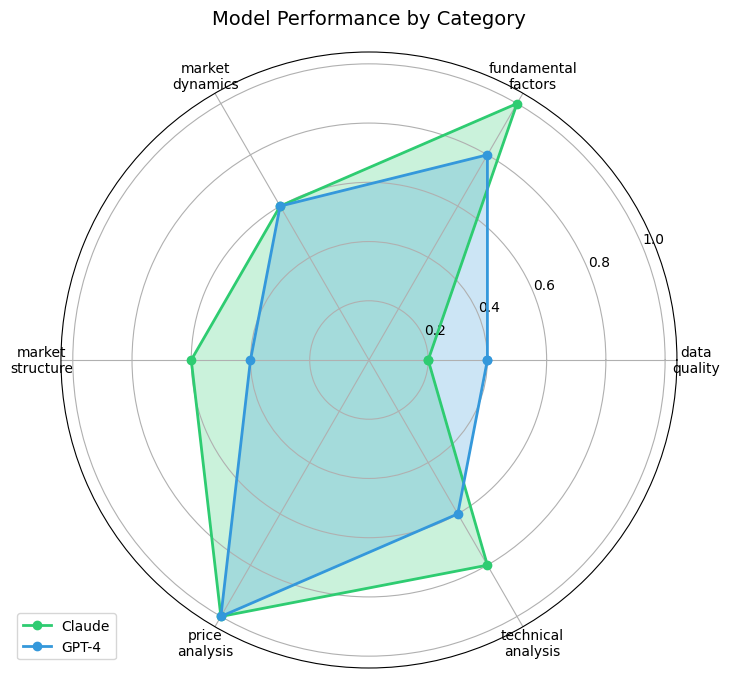


Generating Metrics Comparison Chart...


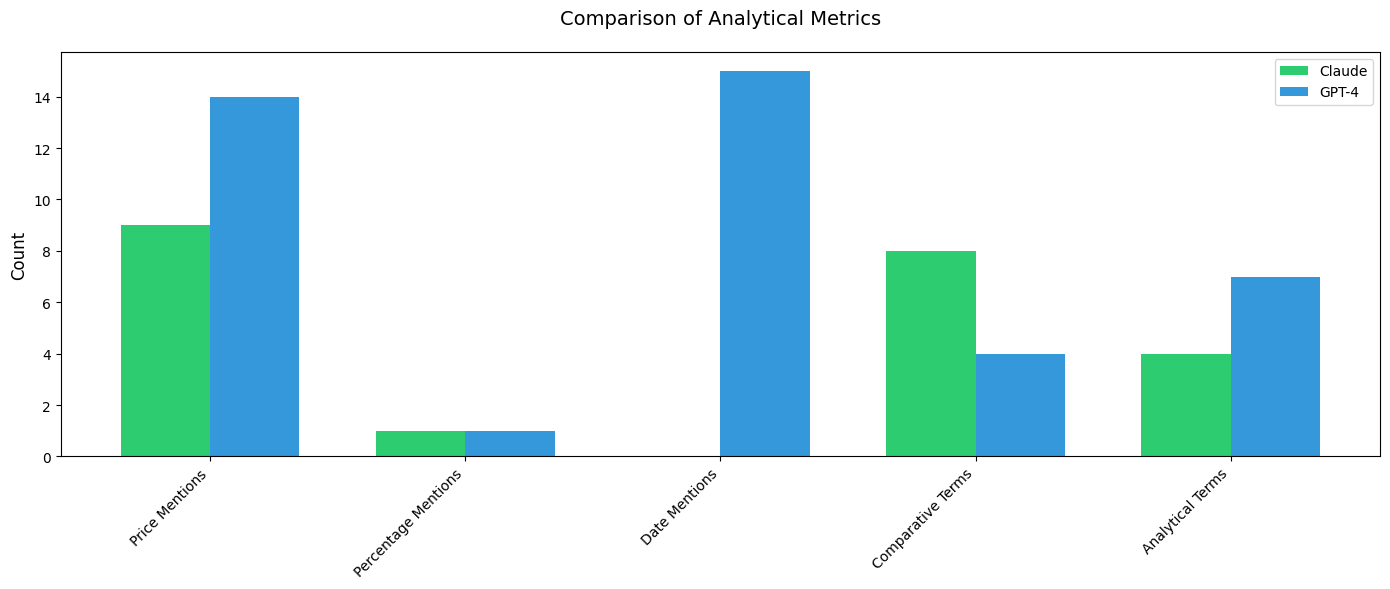


Detailed Evaluation Report:

╔══════════════════════════════════════════════════════════════════╗
║                 Commodities Analysis Evaluation Report           ║
╚══════════════════════════════════════════════════════════════════╝

📊 Overall Performance
--------------------
🏆 Winner: Claude (margin: 0.06)

💪 Model Strengths
----------------
Claude:
✓ Excels in: fundamental_factors (1.00), price_analysis (1.00)
⚠ Areas for improvement: data_quality (0.20), market_dynamics (0.60)

GPT-4:
✓ Excels in: price_analysis (1.00), fundamental_factors (0.80)
⚠ Areas for improvement: data_quality (0.40), market_structure (0.40)

📈 Key Differences
---------------
• technical_analysis: 0.20 point difference
• data_quality: 0.20 point difference

📋 Recommendations
---------------
• Improve data_quality analysis across both models
• Improve market_structure analysis across both models



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

class EvaluationVisualizer:
    def __init__(self):
        # Use a basic matplotlib style instead of seaborn
        plt.style.use('default')
        self.colors = ['#2ecc71', '#3498db']  # Green and blue

    def create_category_comparison(self, detailed_results: pd.DataFrame) -> plt.Figure:
        """Create radar chart comparing category scores between models"""
        # Pivot data for radar chart
        pivot_data = detailed_results.pivot(index='model', columns='category', values='score')

        # Set up the radar chart
        categories = pivot_data.columns
        num_cats = len(categories)
        angles = np.linspace(0, 2*np.pi, num_cats, endpoint=False)

        # Close the plot by appending first value
        values_claude = pivot_data.loc['Claude'].values.tolist()
        values_gpt = pivot_data.loc['GPT-4'].values.tolist()
        values_claude += values_claude[:1]
        values_gpt += values_gpt[:1]
        angles = np.concatenate((angles, [angles[0]]))
        categories = list(categories) + [list(categories)[0]]

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))

        # Plot data
        ax.plot(angles, values_claude, 'o-', linewidth=2, label='Claude', color=self.colors[0])
        ax.plot(angles, values_gpt, 'o-', linewidth=2, label='GPT-4', color=self.colors[1])
        ax.fill(angles, values_claude, alpha=0.25, color=self.colors[0])
        ax.fill(angles, values_gpt, alpha=0.25, color=self.colors[1])

        # Set category labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([cat.replace('_', '\n') for cat in categories[:-1]], size=10)

        # Add legend
        ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

        plt.title('Model Performance by Category', pad=20, size=14)
        return fig

    def create_metrics_comparison(self, summary_results: pd.DataFrame) -> plt.Figure:
        """Create bar chart comparing metrics between models"""
        metric_cols = [col for col in summary_results.columns if col.startswith('metric_')]
        metric_data = summary_results[metric_cols].copy()
        metric_data.columns = [col.replace('metric_', '').replace('_', ' ').title() for col in metric_cols]

        fig, ax = plt.subplots(figsize=(14, 6))
        x = np.arange(len(metric_data.columns))
        width = 0.35

        ax.bar(x - width/2, metric_data.iloc[0], width, label='Claude', color=self.colors[0])
        ax.bar(x + width/2, metric_data.iloc[1], width, label='GPT-4', color=self.colors[1])

        ax.set_ylabel('Count', size=12)
        ax.set_title('Comparison of Analytical Metrics', size=14, pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(metric_data.columns, rotation=45, ha='right')
        ax.legend()

        plt.tight_layout()
        return fig

def generate_evaluation_report(detailed_results: pd.DataFrame, summary_results: pd.DataFrame) -> str:
    """Generate a detailed analysis report"""
    overall_scores = summary_results[['model', 'overall_score']]
    winner = overall_scores.iloc[overall_scores['overall_score'].argmax()]['model']
    score_diff = abs(overall_scores.iloc[0]['overall_score'] - overall_scores.iloc[1]['overall_score'])

    # Calculate strengths and weaknesses
    detailed_pivot = detailed_results.pivot(index='model', columns='category', values='score')
    claude_strengths = detailed_pivot.loc['Claude'].nlargest(2)
    claude_weaknesses = detailed_pivot.loc['Claude'].nsmallest(2)
    gpt4_strengths = detailed_pivot.loc['GPT-4o'].nlargest(2)
    gpt4_weaknesses = detailed_pivot.loc['GPT-4o'].nsmallest(2)

    report = f"""
╔══════════════════════════════════════════════════════════════════╗
║                 Commodities Analysis Evaluation Report           ║
╚══════════════════════════════════════════════════════════════════╝

📊 Overall Performance
--------------------
🏆 Winner: {winner} (margin: {score_diff:.2f})

💪 Model Strengths
----------------
Claude:
✓ Excels in: {', '.join(f"{cat} ({score:.2f})" for cat, score in claude_strengths.items())}
⚠ Areas for improvement: {', '.join(f"{cat} ({score:.2f})" for cat, score in claude_weaknesses.items())}

GPT-4:
✓ Excels in: {', '.join(f"{cat} ({score:.2f})" for cat, score in gpt4_strengths.items())}
⚠ Areas for improvement: {', '.join(f"{cat} ({score:.2f})" for cat, score in gpt4_weaknesses.items())}

📈 Key Differences
---------------
{generate_key_differences(detailed_pivot)}

📋 Recommendations
---------------
{generate_recommendations(detailed_pivot)}
"""
    return report

def generate_key_differences(detailed_pivot: pd.DataFrame) -> str:
    differences = (detailed_pivot.loc['Claude'] - detailed_pivot.loc['GPT-4']).abs()
    top_differences = differences.nlargest(2)

    return '\n'.join([f"• {cat}: {diff:.2f} point difference"
                     for cat, diff in top_differences.items()])

def generate_recommendations(detailed_pivot: pd.DataFrame) -> str:
    recommendations = []
    for category in detailed_pivot.columns:
        if detailed_pivot[category].mean() < 0.6:
            recommendations.append(f"• Improve {category} analysis across both models")

    if not recommendations:
        recommendations.append("• Both models show good overall performance")

    return '\n'.join(recommendations)

def display_complete_evaluation(detailed_results: pd.DataFrame, summary_results: pd.DataFrame):
    """Display complete evaluation with visualizations and report"""
    # Create visualizer
    visualizer = EvaluationVisualizer()

    # Generate and display visualizations
    print("Generating Category Comparison Chart...")
    radar_fig = visualizer.create_category_comparison(detailed_results)
    plt.show()

    print("\nGenerating Metrics Comparison Chart...")
    metrics_fig = visualizer.create_metrics_comparison(summary_results)
    plt.show()

    # Generate and display report
    print("\nDetailed Evaluation Report:")
    print("=========================")
    report = generate_evaluation_report(detailed_results, summary_results)
    print(report)

# Run the complete evaluation with the current results
display_complete_evaluation(detailed_results, summary_results)

In [ ]:
@dataclass
class ModelConfig:
    """Configuration class to hold model information"""
    name: str      # Exact model name as configured
    provider: str  # Model provider

    @property
    def display_name(self) -> str:
        return f"{self.provider} ({self.name})"

    @classmethod
    def from_openai_model(cls, model: OpenAI) -> 'ModelConfig':
        return cls(
            name=model.model,  # Using exact model name: "gpt-4o-mini"
            provider="OpenAI"
        )

    @classmethod
    def from_anthropic_model(cls, model: Anthropic) -> 'ModelConfig':
        return cls(
            name=model.model,  # Using exact model name: "claude-3-5-sonnet-20240620"
            provider="Anthropic"
        )

class EvaluationVisualizer:
    def __init__(self):
        plt.style.use('default')
        self.colors = ['#2ecc71', '#3498db']  # Green and blue

    def create_category_comparison(self, detailed_results: pd.DataFrame, model_configs: Dict[str, ModelConfig]) -> plt.Figure:
        """Create radar chart comparing category scores between models"""
        # Update model names to exact versions
        detailed_results = detailed_results.copy()
        detailed_results['model'] = detailed_results['model'].map(
            {name: config.display_name for name, config in model_configs.items()}
        )

        # Pivot data for radar chart
        pivot_data = detailed_results.pivot(index='model', columns='category', values='score')

        # Create visualization
        categories = pivot_data.columns
        num_cats = len(categories)
        angles = np.linspace(0, 2*np.pi, num_cats, endpoint=False)

        values = [pivot_data.iloc[i].values.tolist() + [pivot_data.iloc[i][0]] for i in range(len(pivot_data))]
        angles = np.concatenate((angles, [angles[0]]))
        categories = list(categories) + [list(categories)[0]]

        fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))

        for i, (model, value) in enumerate(zip(pivot_data.index, values)):
            ax.plot(angles, value, 'o-', linewidth=2, label=model, color=self.colors[i])
            ax.fill(angles, value, alpha=0.25, color=self.colors[i])

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([cat.replace('_', '\n') for cat in categories[:-1]], size=10)
        ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

        plt.title('Model Performance by Category', pad=20, size=14)
        return fig

    def create_metrics_comparison(self, summary_results: pd.DataFrame, model_configs: Dict[str, ModelConfig]) -> plt.Figure:
        """Create bar chart comparing metrics between models"""
        summary_results = summary_results.copy()
        summary_results['model'] = summary_results['model'].map(
            {name: config.display_name for name, config in model_configs.items()}
        )

        metric_cols = [col for col in summary_results.columns if col.startswith('metric_')]
        metric_data = summary_results[metric_cols].copy()
        metric_data.index = summary_results['model']
        metric_data.columns = [col.replace('metric_', '').replace('_', ' ').title() for col in metric_cols]

        fig, ax = plt.subplots(figsize=(14, 6))
        x = np.arange(len(metric_data.columns))
        width = 0.35

        ax.bar(x - width/2, metric_data.iloc[0], width,
              label=metric_data.index[0], color=self.colors[0])
        ax.bar(x + width/2, metric_data.iloc[1], width,
              label=metric_data.index[1], color=self.colors[1])

        ax.set_ylabel('Count', size=12)
        ax.set_title('Comparison of Analytical Metrics', size=14, pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(metric_data.columns, rotation=45, ha='right')
        ax.legend()

        plt.tight_layout()
        return fig

def evaluate_commodity_responses(query: str, model1_agent, model2_agent, model1_llm, model2_llm):
    """Run evaluation with exact model configurations"""
    # Create model configurations
    model1_config = ModelConfig.from_anthropic_model(model1_llm)
    model2_config = ModelConfig.from_openai_model(model2_llm)

    # Get responses
    response1 = model1_agent.chat(query)
    response2 = model2_agent.chat(query)

    # Initialize evaluator
    evaluator = EnhancedCommoditiesEvaluator()

    # Use exact model names for responses
    responses = {
        model1_config.name: str(response1),
        model2_config.name: str(response2)
    }

    model_configs = {
        model1_config.name: model1_config,
        model2_config.name: model2_config
    }

    detailed_results, summary_results = evaluator.compare_responses(responses)

    return detailed_results, summary_results, model_configs

def display_evaluation(query: str):
    """Display evaluation with exact model names"""
    detailed_results, summary_results, model_configs = evaluate_commodity_responses(
        query=query,
        model1_agent=claude_agent,
        model2_agent=oai_agent,
        model1_llm=anthropic_llm,
        model2_llm=openai_llm
    )

    print("\nModel Configurations:")
    print("====================")
    for config in model_configs.values():
        print(f"\n{config.provider}:")
        print(f"Model: {config.name}")

    visualizer = EvaluationVisualizer()

    print("\nGenerating visualizations...")
    visualizer.create_category_comparison(detailed_results, model_configs)
    plt.show()

    visualizer.create_metrics_comparison(summary_results, model_configs)
    plt.show()

    print("\nDetailed Evaluation Report:")
    print("=========================")
    report = generate_evaluation_report(detailed_results, summary_results, model_configs)
    print(report)

    return detailed_results, summary_results

# Run evaluation
query = "Provide fundamental analysis for aluminium"
detailed_results, summary_results = display_evaluation(query)